In [1]:
print("test")

test


In [2]:
import matplotlib.pyplot as plt
from project_classes import *
from functions import *

In [3]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
# season = "2018_Antarctica_DC8" # a layerData season
season = "2016_Antarctica_DC8" # a season with both layer and layerData
# season = "2014_Antarctica_DC8" # a layerData season
# flight = "20181030_01"  # the flight date and frame number
# flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
flight = "20161024_05"
# flight = "20161111_05"
# flight = "20161024_05"
# flight = '20141026_06'
# file_name = "layer_export_" + flight + ".pickle"
file_name = "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
testing = False

In [4]:
"""
read in the layers from the layer files and save them to a pickle file
"""
# mat_pickler_layer(season, flight, testing_mode=testing)  # make it
mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
layers = read_layers(file_name)  # read in the layers from the pickle file

# TODO: figure out the difference in file structure between the h5py and sio based pickler outputs

Reading data files...
--------------------
--------------------
C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20161024_05.pickle  saved in local directory of this python file.
--------------------

Reading pickle file...
--------------------
Surface
Bottom
--------------------



### read in the iceflow data from the iceflow data files and save them to a pickle file

In [5]:
if not os.path.isfile("C:\\Users\\rj\\Documents\\cresis_project\\iceflow\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\rj\\Documents\\cresis_project\\iceflow\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]

The iceflow data pickle file was found and loaded.


In [7]:
# if the file at filename exists, read in the intersection_indices and intersection_points from the pickle file
# otherwise, find the intersection_indices and intersection_points and save them to a pickle file
filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"
if not os.path.isfile(filename):  # if the file does not exist
    print(f"File {filename} does not exist. Making it...")
    intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
    with open(filename, 'wb') as file:
        pickle.dump(intersection_indices, file)
        pickle.dump(intersection_points, file)
        pickle.dump(segment_ends, file)
    print(f"intersection_indices and intersection_points saved to {filename}")
else:
    with open(filename, 'rb') as file:
        intersection_indices = pickle.load(file)
        intersection_points = pickle.load(file)
        segment_ends = pickle.load(file)
    print(f"intersection_indices and intersection_points loaded from {filename}")

intersection_indices and intersection_points loaded from C:\Users\rj\Documents\cresis_project\pickle_jar\2016_Antarctica_DC8_20161024_05_crossover_points.pickle


In [33]:
# TODO: identify why this is still here and not in the functions file
    # because it is still being tweaked
# TODO: consider normalizing to the elevation, not the surface
    # i.e. instead of having the surface be flat, have it represent the actual topology
    # really only useful for places where the surface is not basically flat 
def plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=False, refractive_index=1.77, cross_index=0, filename=None):
    """
    :param layers: a list of Layer objects
    :param intersection_indices: a list of indices in the lat-lon arrays where the flight path
    crosses over itself
    :param intersection_points: a list of lat-lon points where the flight path crosses over itself
    :return: nothing (plots the layers and the map)
    """
    plt.figure(figsize=(16, 8), layout='constrained')
    # print("Plotting layers...")
    # print("--------------------")
    # print("Adjusting for surface twtt...")
    for layer in layers:
        corrected_layer = layer.twtt - layers[0].twtt
        layer.twtt_corrected = corrected_layer


    # ax2 will be the layer plot
    # plt.subplot(1, 2, 1)

    # plot the layer depths vs index for 500 points before and after the first
    # crossover point for each layer.
    # also plot the layer depths vs index for 500 points before and after the
    # second crossover point for each layer.
    offset = 500
    # plot the corrected twtt for each layer
    plt.plot(
        layers[0].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[0].layer_name)
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[0][0] - offset:intersection_indices[cross_index][0] + offset],
        label=layers[1].layer_name + ' segment 1')
    plt.plot(
        layers[1].twtt_corrected[intersection_indices[0][1] - offset:intersection_indices[cross_index][1] + offset],
        label=layers[1].layer_name + ' segment 2')

    # invert the y-axis because the twtt increases with depth
    plt.gca().invert_yaxis()
    # plot the crossover point on the plot
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[0][0], color='red',
                label='X Point 1')
    plt.scatter(offset, twtt_at_point(layers[1], layers[0],
                                      intersection_indices, quiet=True)[0][1], color='green',
                label='X Point 2')
    
    # print the twtt at the crossover point on both segments
    twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)[0]
    # print(f"twtt: {twtt}")
    
    
    # plot a line at the crossover point
    plt.axvline(x=offset, color='black', label='X Point', linestyle='--', linewidth=0.3)

    # set the y axis to be in microseconds instead of seconds
    plt.ylabel(f"Adjusted Two Way Travel Time ({chr(956)}s)")
    plt.xlabel("Index")

    # force the y values to be displayed in 1e-6 ticks (microseconds) instead of 1e-5 ticks (tens of microseconds)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)

    def s_to_ms(x, pos):
        """
        :param x: the x value
        :param pos: the position
        :return: the x value in milliseconds
        """
        return '%1.1f' % (x * 1e6)

    # set the y axis to be in microseconds instead of seconds
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(s_to_ms))
    plt.legend( fontsize='smaller', loc='upper right', bbox_to_anchor=(1, 0.9))

    # make the right side y axis show the depth in meters by converting the twtt to depth using the refractive index
    min_y, max_y = plt.ylim()
    n = refractive_index
    c = 299792458  # m/s
    v = c / n
    # depth = twtt * v / 2
    scale_factor = v / 2
    print(f"scale factor: {scale_factor}")
    plt.twinx()
    plt.ylim(min_y * scale_factor, max_y * scale_factor)
    plt.ylabel("Depth (m)")

    # make the top of the x axis be the distance in meters by converting the lat-lon to distance using the haversine formula
    min_x, max_x = plt.xlim()
    scale_factor = latlon_dist((layers[0].lat[0], layers[0].lon[0]), (layers[0].lat[1], layers[0].lon[1]))
    # print(f"scale factor: {scale_factor}")
    plt.twiny()
    plt.xlim(min_x * scale_factor, max_x * scale_factor)
    plt.xlabel("Distance (m)")

    plt.title("Adjusted Two Way Travel Time vs Index")
    plt.show()


def plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=None):
    """
    plot the map
    """
    plot_it = True
    
    if plot_it:
        plt.figure(figsize=(16, 8), layout='constrained')
    print("Plotting map...")
    # TODO: add an offset to the zoom settings so that the crossover point is in the center of the zoomed in map
    offset = 500  # this is not that offset

    # this code sets up a polar stereographic map of antarctica with the South Pole in the center
    zoom_out_to_continent = not zoom
    if zoom_out_to_continent:
        llcrnrx = -400000
        llcrnry = -400000
        urcrnrx = 250000
        urcrnry = 250000
    else:
        llcrnrx = -100000
        llcrnry = -100000
        urcrnrx = 100000
        urcrnry = 100000
    lat_0 = intersection_points[cross_index][0]
    lon_0 = intersection_points[cross_index][1]
    # print(f"debug: lat_0: {lat_0}, lon_0: {lon_0}")
    if plot_it:
        m = Basemap(projection='ortho', lat_0=lat_0, lon_0=lon_0, llcrnrx=llcrnrx,
                    llcrnry=llcrnry, urcrnrx=urcrnrx, urcrnry=urcrnry, resolution='c')
        # m = Basemap(projection='spstere', lat_0=-90, lat_ts=-71, lon_0=0, boundinglat=-80, resolution='c')
        m.drawcoastlines()
        m.fillcontinents(color='grey', lake_color='aqua')
        m.drawparallels(np.arange(-80., 81., 20.))
        m.drawmeridians(np.arange(-180., 181., 20.))
        m.drawmapboundary(fill_color='aqua')
    
        # plot the flight path
        m.plot(layers[0].lon, layers[0].lat, latlon=True, color='lightgreen', linewidth=1)
        # plot the section of the flight path in the plot above
        m.plot(layers[0].lon[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset],
               layers[0].lat[intersection_indices[0][0] - offset:intersection_indices[0][0] + offset], latlon=True,
               color='red', linewidth=1)
        m.plot(layers[0].lon[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset],
               layers[0].lat[intersection_indices[0][1] - offset:intersection_indices[0][1] + offset], latlon=True,
               color='green', linewidth=1)
        # plot labels for the flight paths at their start points
        plt.text(
            m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[0],
            m(layers[0].lon[intersection_indices[0][0] - offset], layers[0].lat[intersection_indices[0][0] - offset])[1],
            '\nsegment 1', fontsize='smaller', fontweight='bold', ha='right', va='top', color='red')
        plt.text(
            m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[0],
            m(layers[0].lon[intersection_indices[0][1] - offset], layers[0].lat[intersection_indices[0][1] - offset])[1],
            '\nsegment 2', fontsize='smaller', fontweight='bold', ha='left', va='top', color='green')
        # plot the South Pole
        # m.scatter(0, -90, latlon=True, color='black', linewidth=1, label='South Pole')
        # plot the crossover points
        for point in intersection_points:
            m.scatter(point[1], point[0], latlon=True, color='darkred', linewidth=1, label='Crossover Point')
            plt.text(m(point[1], point[0])[0], m(point[1], point[0])[1] - 10000, f'{intersection_points.index(point) + 1}\n\n',
                     fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # m.scatter(intersection_points[cross_index][1], intersection_points[cross_index][0], latlon=True, color='darkred',
    #           linewidth=1, label='Crossover Point')
    # plt.text(m(intersection_points[cross_index][1], intersection_points[cross_index][0])[0],
    #          m(intersection_points[cross_index][1], intersection_points[cross_index][0])[1] - 10000,
    #          'Crossover Point\n\n',
    #          fontsize='smaller', fontweight='bold', ha='center', va='top', color='darkred')

    # plot the the ice flow direction at the crossover point
    for i in range(len(intersection_indices)):
    # for i in range(1):
        print(f"cross index: {i+1}")
        cross_lat = intersection_points[i][0]
        cross_lon = intersection_points[i][1]
        if cross_lon < 0:
            cross_lon = 360 + cross_lon
        cross_x, cross_y = latlon_to_xy(cross_lat, cross_lon)  
        """Outputs x and y in EPSG:3031"""
        print(f"cross_lat: {cross_lat:.8}, cross_lon: {cross_lon:.8f}") 
        print(f"cross_x: {cross_x:.4f}, cross_y: {cross_y:.4f}")
        
        # nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(cross_x, cross_y, iceflow_data, max_radius=10)
        print(section_break)
        # nearest_y_index, nearest_x_index = latlon_to_nearest_unmasked_index(cross_lat, cross_lon, iceflow_data, max_radius=10)
        nearest_x_index, nearest_y_index = latlon_to_nearest_unmasked_index(cross_lat, cross_lon, iceflow_data, max_radius=10)
        print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
        """Outputs the nearest x and y indices to the x and y EPSG:3031 values"""
        
        
        nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]  # latitude = iceflow_data[4]
        nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]  # longitude = iceflow_data[5]
        # nearest_lon = - (iceflow_data[5][nearest_x_index][nearest_y_index] - 270)  # longitude = iceflow_data[5]
        
        # print(f"nearest_lat: {nearest_lat:.4f}, nearest_lon: {nearest_lon:.4f}")
        print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")

        nearest_x, nearest_y = index_to_x(nearest_x_index), index_to_y(nearest_y_index)
        print(f"nearest_x: {nearest_x:.4f}, nearest_y: {nearest_y:.4f}")
    
        # flow = flow_at_x_y_index(nearest_x_index, nearest_y_index, iceflow_data)
        vx, vy = iceflow_data[2][nearest_y_index][nearest_x_index], iceflow_data[3][nearest_y_index][nearest_x_index]
        flow = [vx, vy]
        print(f"flow at nearest: {flow}")
        
        flow_heading = xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow[0], flow[1])[0]
        # m.quiver(intersection_points[0][1], intersection_points[0][0], 1000 * np.cos(np.radians(flow_heading)),
        #          1000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        # plot the ice flow vector in the upper right corner as a quiver
        

        print("")
        print(f"Diff x: {(cross_x - nearest_x):.1f}, Diff y: {(cross_y - nearest_y):.1f}")
        print("")
        print(section_break)
        print(section_break)
        print("")
        
        
        # if plot_it:
        #     m.quiver(intersection_points[0][1]+2.5, intersection_points[0][0]+0.7, 10000 * np.cos(np.radians(flow_heading)), 10000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        #     plt.text(m(intersection_points[0][1]+2.5, intersection_points[0][0]+0.6)[0], m(intersection_points[0][1]+5, intersection_points[0][0]+0.8)[1], 'Ice Flow Vector\n\n', fontsize='smaller', fontweight='bold', ha='center', va='top', color='blue')
        #     x, y = m(0, -90)
        mag = np.sqrt(vx**2 + vy**2)
        # m.quiver(intersection_points[i][1], intersection_points[i][0], mag  * np.cos(np.radians(flow_heading)),
        #             mag * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        # plt.text(m(intersection_points[i][1], intersection_points[i][0])[0], m(intersection_points[i][1], intersection_points[i][0])[1] - 100, 'Ice Flow Vector\n\n', fontsize='smaller', fontweight='bold', ha='center', va='top', color='blue')
        m.quiver(nearest_x, nearest_y, 10000 * np.cos(np.radians(flow_heading)), 10000 * np.sin(np.radians(flow_heading)), latlon=True, color='blue', label='Ice Flow Vector')
        x, y = m(0, -90)
    
        # plt.text(x, y, '\nSouth Pole', fontsize='smaller', fontweight='bold', ha='center', va='top', color='black')

    center_x, center_y = latlon_to_xy(intersection_points[cross_index][0], intersection_points[cross_index][1])
    center_x = x_to_index(center_x)
    center_y = y_to_index(center_y)
    search_range = 750
    steps = 50
    start_time = time.time()
    for x in range(-1 * search_range + center_x, search_range + center_x, steps):
        current = x + search_range - center_x    
        progress_bar(current,  2 * search_range, start_time)
        for y in range(-1 * search_range + center_y, search_range + center_y, steps):
            if not (
                np.ma.is_masked(iceflow_data[2][y][x]) and np.ma.is_masked(iceflow_data[3][y][x])
                ):
                # print(f"np.isnan(iceflow_data[2][y][x]): {np.isnan(iceflow_data[2][y][x])}")
                # print(f"np.isnan(iceflow_data[3][y][x]): {np.isnan(iceflow_data[3][y][x])}")
                # print(f"x-index: {x}, y-index: {y}\nx: {index_to_x(x)}, y: {index_to_y(y)}")
                vx = 1 * iceflow_data[2][y][x]
                vy = 1 * iceflow_data[3][y][x]
                flow = [vx, vy]
                flow_heading = xyindex_vector_to_heading(x, y, flow[0], flow[1])[0]
                # print(f"flow at nearest: {flow_heading}")
                scale = 0.0005
                mag = np.sqrt(vx**2 + vy**2) * scale
                lat = iceflow_data[4][y][x]
                lon = iceflow_data[5][y][x]
                # print(f"lat: {lat}, lon: {lon}")
                # print(f"flow at nearest: {flow}")
                m.scatter(lon, lat, latlon=True, color='darkred', s=0.75)
                # plot a line of length mag in the direction of the flow vector to show the flow vector
                endpt = [lon + mag * np.cos(np.radians(flow_heading)), lat + mag * np.sin(np.radians(flow_heading))]
                m.plot([lon, endpt[0]], [lat, endpt[1]], latlon=True, color='blue', linewidth=0.5)
                
            # else:
                # print(f"masked at x: {x}, y: {y}")
        # scatter the south pole
        # m.scatter(0, -90, latlon=True, color='white', s=5)
        print("")
        
    if plot_it: 
        plt.title("Lat-Lon Map")
        # set tight layout
        # plt.tight_layout()
    
        # save the plot
        if filename:
            # plt.savefig(f"{filename}.png", dpi=250)
            dir = "C:\\Users\\rj\Documents\\cresis_project\\screens\\"
            savename = f"{dir}{filename}_map.png"
            print(f"saving to {savename}...")
            plt.savefig(savename, dpi=250)
        
        print("drawing to screen...")
        plt.show()

    # print("plotted map")
    # print(section_break + "\n")

Plotting map...
cross index: 1
cross_lat: -81.118162, cross_lon: 330.26490484
cross_x: -479569.5607, cross_y: 839579.5925
--------------------
checking indices: (5157, 4356)
The calculated indices are unmasked, no need to search
nearest_x_index: 5157, nearest_y_index: 4356
nearest_lat: -81.1174078311801, nearest_lon: 330.282678652
nearest_x: -479700.0000, nearest_y: 840150.0000
flow at nearest: [-176.06517, -119.391495]

Diff x: 130.4, Diff y: -570.4

--------------------
--------------------

cross index: 2
cross_lat: -81.167687, cross_lon: 331.69420132
cross_x: -455912.2053, cross_y: 846515.5992
--------------------
checking indices: (5209, 4340)
The calculated indices are unmasked, no need to search
nearest_x_index: 5209, nearest_y_index: 4340
nearest_lat: -81.16362069338335, nearest_lon: 331.7059003807609
nearest_x: -456300.0000, nearest_y: 847350.0000
flow at nearest: [-189.62747, -165.06949]

Diff x: 387.8, Diff y: -834.4

--------------------
--------------------

cross index: 3

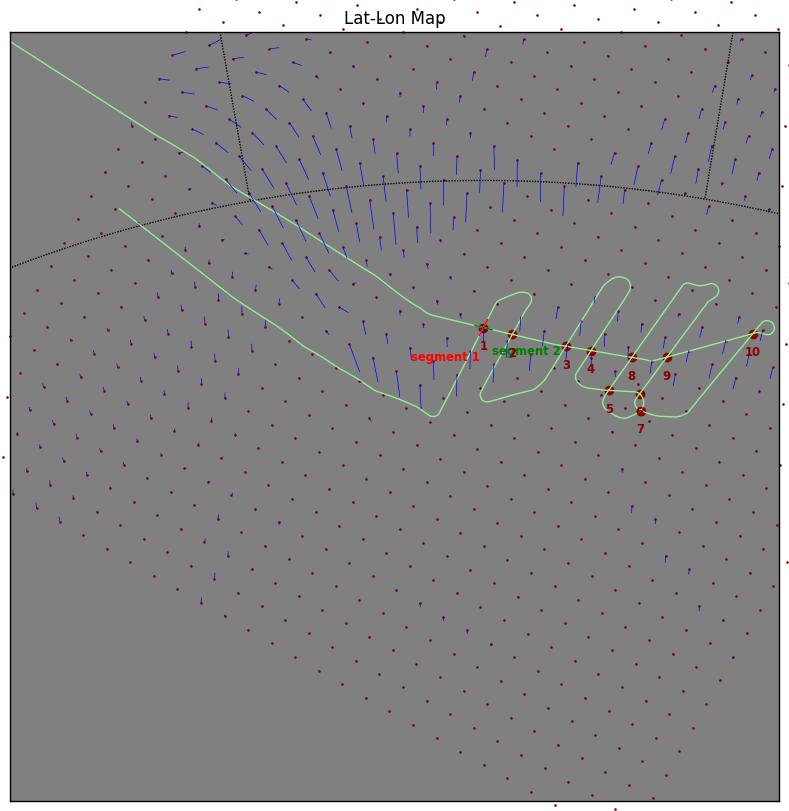

In [34]:
# print(segment_ends[0][0][0][0])
# for point in intersection_points:
    # print(point[0])
# plot_layers_at_cross(layers, intersection_indices, segment_ends)
# plot_layers_at_cross(layers, intersection_indices, intersection_points, zoom=zoom, cross_index=0, filename=(season + flight + "crossover"))
plot_map(layers, intersection_indices, intersection_points, iceflow_data, season, flight,  zoom=False, cross_index=0, filename=(season + flight + "crossover")) 

# TODO: smaller quivers on same map with every direction point
    - direction by magnitude

# 20Jun24 **NOT BELOW HERE UNLESS FLOW VECTOR IS WORKING**

In [36]:
# repeat the above for every crossover point
flow_xy = [] # the flow vector in xy 
flow_heading_full = [] # the flow vector heading in angle1, angle2, distance (in meters)
flow_heading = []
plane_heading_1 = []
plane_heading_2 = []
angle = [] # the angle between the flow vector and the plane heading
twtt = twtt_at_point(layers[1], layers[0], intersection_indices, quiet=True)
delta_twtt = []

for i in range(len(intersection_indices)):
# for i in range(1):
    # convert the lat-lon point to xy and then to indices
    lat, lon = intersection_points[i] 
    print(f"lat-lon {i}: {lat, lon}")
    
    x, y = latlon_to_xy(lat, lon)
    print(f"x: {x}, y: {y}")
    
    x_index, y_index = x_to_index(x), y_to_index(y)
    print(f"x_index: {x_index}, y_index: {y_index}")
    
    nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)
    
    # find the nearest good iceflow_data to the crossover point
    # nearest_lat = iceflow_data[4][nearest_x_index][nearest_y_index]
    # nearest_lon = iceflow_data[5][nearest_x_index][nearest_y_index]
    nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]
    nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]
    print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")

    # flow_xy.append([iceflow_data[2][nearest_x_index][nearest_y_index], iceflow_data[3][nearest_x_index][nearest_y_index]])
    
    vx = 1 * iceflow_data[2][nearest_y_index][nearest_x_index]
    vy = 1 * iceflow_data[3][nearest_y_index][nearest_x_index]
    flow_xy.append([vx, vy])

    print(f"flow at nearest: {flow_xy[i]}")
    
    # find the heading of the flow vector   
    flow_heading_full.append(xyindex_vector_to_heading(nearest_x_index, nearest_y_index, flow_xy[i][0], flow_xy[i][1]))
    flow_heading.append(flow_heading_full[i][0])
    print(f"flow_heading[{i}]: {flow_heading[i]}")
    

    # find the heading of the first segment
    plane_heading_1.append(find_heading(layers[0], intersection_indices[i][0]))
    print(f"heading_1[{i}]: {plane_heading_1[i]}")

    # find the heading of the second segment
    plane_heading_2.append(find_heading(layers[0], intersection_indices[i][1]))
    print(f"heading_2[{i}]: {plane_heading_2[i]}")
    
    # plane_flow_angle = min(abs(plane_heading_1[i] - flow_heading[i]), abs(plane_heading_2[i] - flow_heading[i]))
    plane_flow_angle = max(abs(plane_heading_1[i] - flow_heading[i]), abs(plane_heading_2[i] - flow_heading[i]))

    print(f"plane_flow_angle: {plane_flow_angle}")
    angle.append(plane_flow_angle)
    
    # find the twtt at the crossover point on both segments
    # print(f"twtt{i}: {twtt[i]}")
    # delta_twtt.append(twtt[i][1] - twtt[i][0])
    # append the absolute value of the twtt
    delta_twtt.append(abs(twtt[i][1] - twtt[i][0]))
    print(f"delta_twtt[{i}]: {delta_twtt[i]}")
    
    print(section_break)


length = len(delta_twtt)
while i < length: # remove any nan valued points from the lists
    if math.isnan(delta_twtt[i]):
        delta_twtt.pop(i)
        flow_xy.pop(i)
        angle.pop(i)
        # magnitude.pop(i)
        plane_heading_1.pop(i)
        plane_heading_2.pop(i)
        intersection_indices.pop(i)
        intersection_points.pop(i)
        print(f"intersection {i} removed")
        print(section_break)
        length -= 1
    else:
        i += 1

lat-lon 0: (-81.11816244525122, 330.2649048355562)
x: -479569.56069901184, y: 839579.5925020133
x_index: 5157, y_index: 4356
nearest_lat: -81.1174078311801, nearest_lon: 330.282678652
flow at nearest: [-176.06517028808594, -119.39149475097656]
flow_heading[0]: -94.41645213989642
heading_1[0]: 27.296731944188767
heading_2[0]: -76.64420014071321
plane_flow_angle: 121.71318408408519
delta_twtt[0]: 3.678631648453771e-08
--------------------
lat-lon 1: (-81.16768709742837, 331.6942013208803)
x: -455912.20531389076, y: 846515.5991654578
x_index: 5209, y_index: 4340
nearest_lat: -81.16362069338335, nearest_lon: 331.7059003807609
flow at nearest: [-189.62747192382812, -165.06948852539062]
flow_heading[1]: -102.73670324628206
heading_1[1]: -152.68419768944278
heading_2[1]: -78.0688750575966
plane_flow_angle: 49.94749444316072
delta_twtt[1]: 6.53952213210227e-08
--------------------
lat-lon 2: (-81.23895935598836, 334.3761108368818)
x: -412435.5238477294, y: 859899.0699908467
x_index: 5306, y_in

In [37]:
for i in range(len(flow_heading)):
    print(f"flow_heading[{i}]: {flow_heading[i]}")
    print(f"plane_heading_1[{i}]: {plane_heading_1[i]}")
    print(f"plane_heading_2[{i}]: {plane_heading_2[i]}")
    print(f"plane_heading_1 - flow_heading[{i}]: {abs(plane_heading_1[i] - flow_heading[i])}\n")


flow_heading[0]: -94.41645213989642
plane_heading_1[0]: 27.296731944188767
plane_heading_2[0]: -76.64420014071321
plane_heading_1 - flow_heading[0]: 121.71318408408519

flow_heading[1]: -102.73670324628206
plane_heading_1[1]: -152.68419768944278
plane_heading_2[1]: -78.0688750575966
plane_heading_1 - flow_heading[1]: 49.94749444316072

flow_heading[2]: -109.70765848389644
plane_heading_1[2]: 27.635792037663514
plane_heading_2[2]: -84.5365258822481
plane_heading_1 - flow_heading[2]: 137.34345052155996

flow_heading[3]: -73.51505771920186
plane_heading_1[3]: -152.12376300511113
plane_heading_2[3]: -85.87956659571798
plane_heading_1 - flow_heading[3]: 78.60870528590927

flow_heading[4]: 3.344858192705014
plane_heading_1[4]: 86.67522593074801
plane_heading_2[4]: 28.410138445929714
plane_heading_1 - flow_heading[4]: 83.330367738043

flow_heading[5]: -8.752288310271995
plane_heading_1[5]: 120.3789439325446
plane_heading_2[5]: -151.37252662758883
plane_heading_1 - flow_heading[5]: 129.1312322

# TODO: functionize this plot once it works

theta: 121.71318408408519, phi: 103.94093208490197 for i: 0
 cos(theta): -0.5256674136246471, sin(phi): 0.9705446150522722
theta: 49.94749444316072, phi: 74.61532263184618 for i: 1
 cos(theta): 0.6434893388651259, sin(phi): 0.9641663875299833
theta: 137.34345052155996, phi: 112.17231791991162 for i: 2
 cos(theta): -0.7354286693231797, sin(phi): 0.9260530280390508
theta: 78.60870528590927, phi: 66.24419640939315 for i: 3
 cos(theta): 0.197508399713711, sin(phi): 0.9152706795010858
theta: 83.330367738043, phi: 58.265087484818295 for i: 4
 cos(theta): 0.11614432339323623, sin(phi): 0.8504907614700552
theta: 142.62023831731682, phi: 271.75147056013344 for i: 5
 cos(theta): -0.7946291114684981, sin(phi): -0.999532806702464
theta: 172.63694672551492, phi: 253.1309436773651 for i: 6
 cos(theta): -0.9917540090095148, sin(phi): -0.9569704437691908
theta: 85.40844750194489, phi: 116.0863717545787 for i: 7
 cos(theta): 0.08005196164682202, sin(phi): 0.8981321932988672
theta: 56.25803400530627, ph

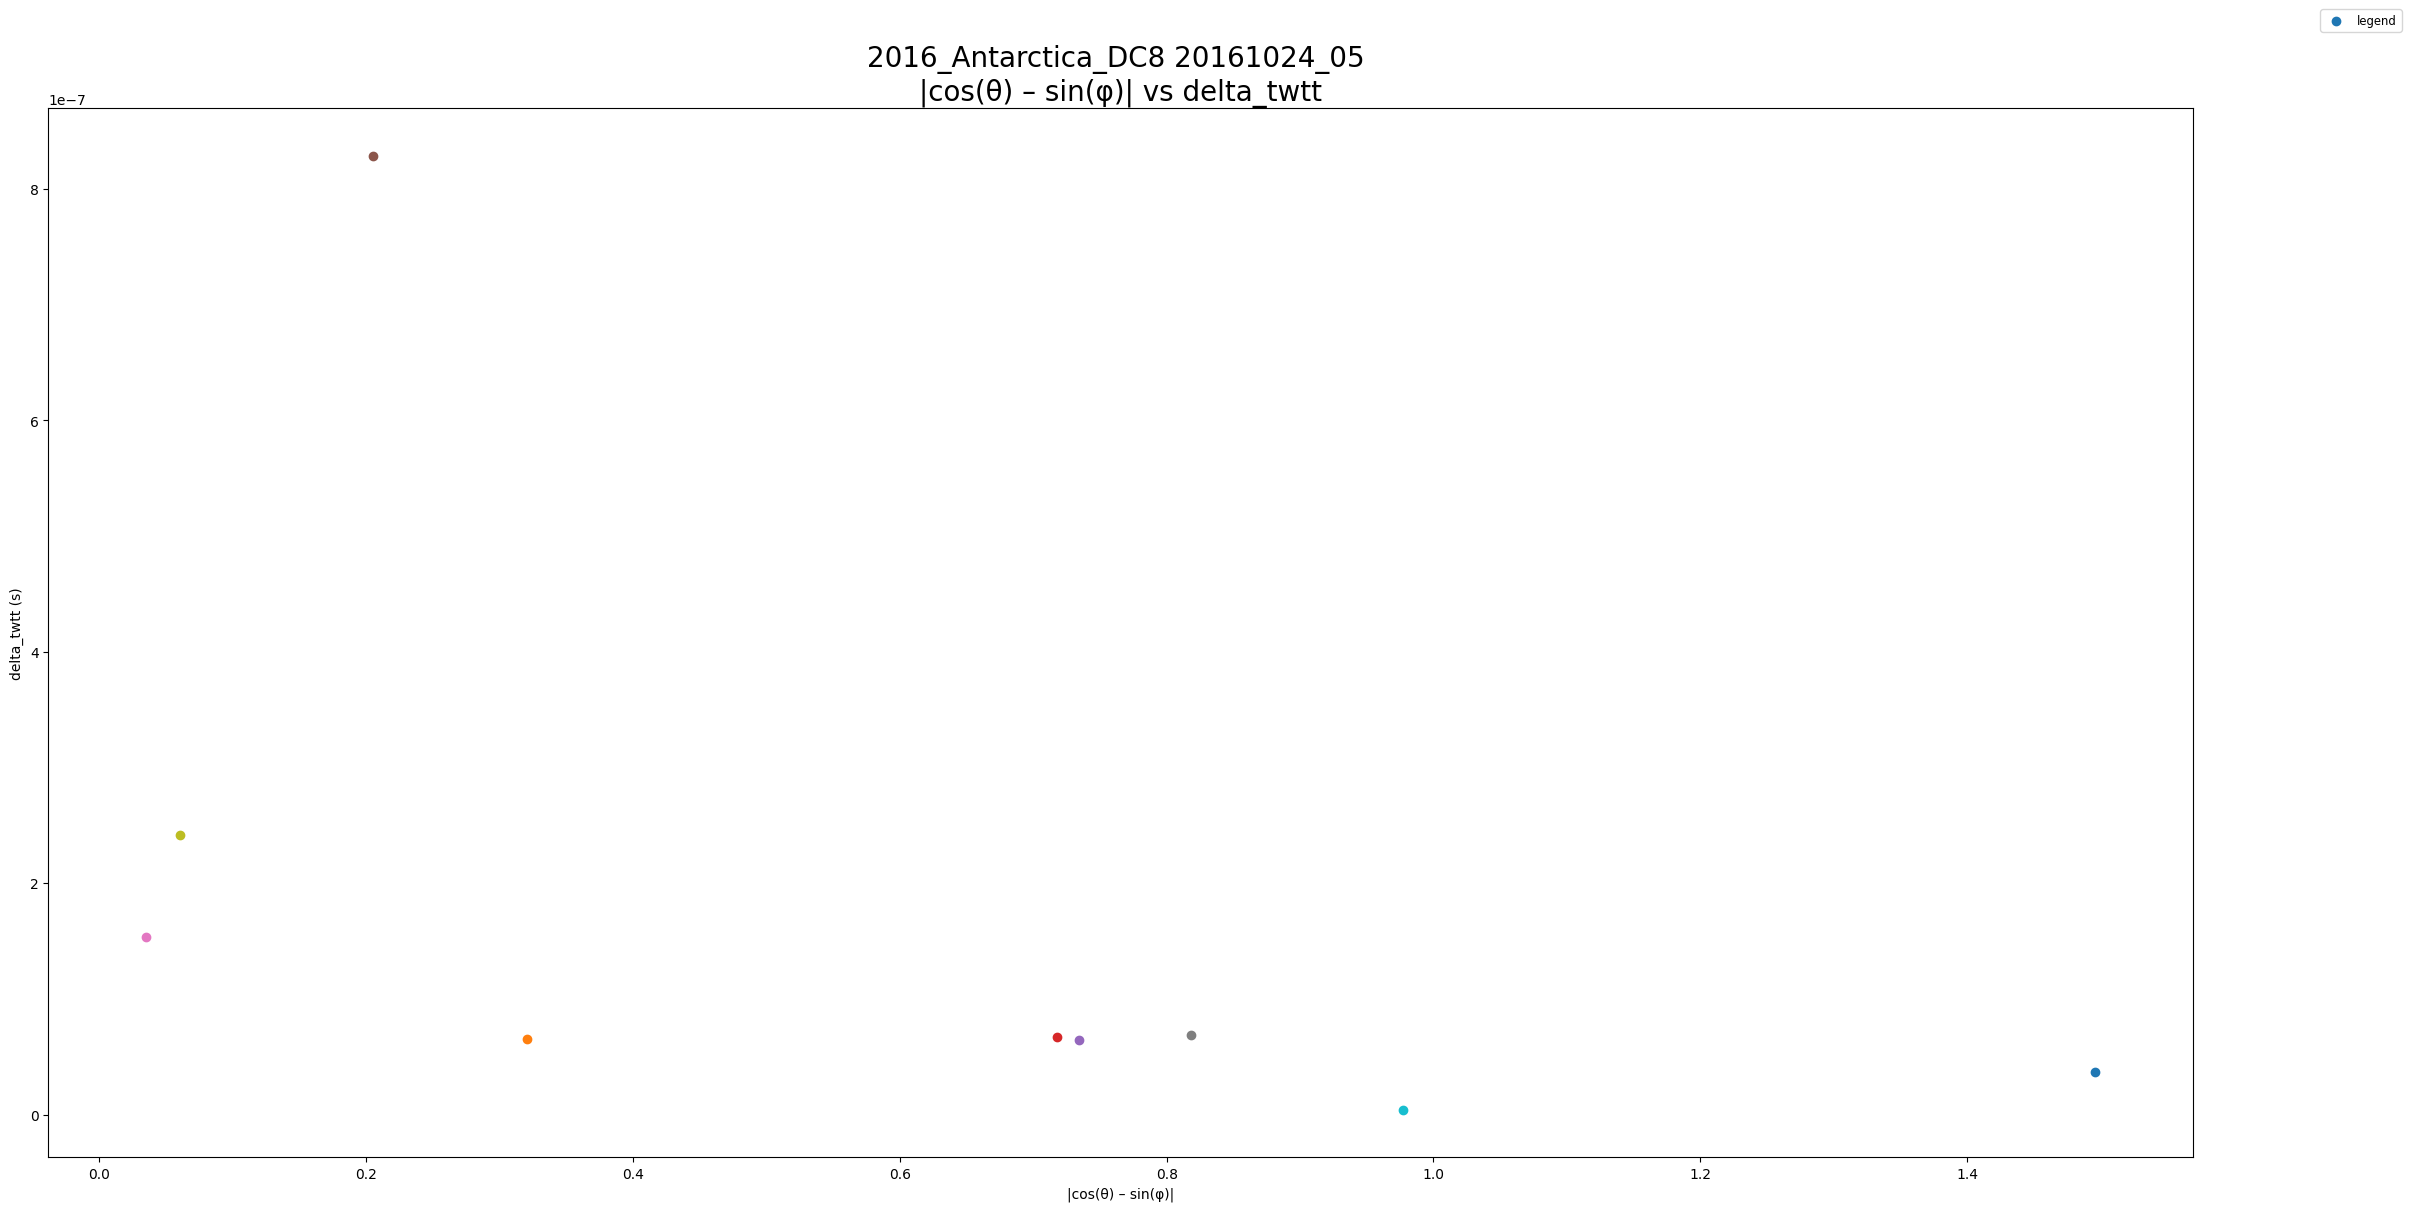

saved plot as 2016_Antarctica_DC8_20161024_05_cos_angle_heading_vs_delta_twtt.png


In [39]:
# TODO: verify this plot is correct
# TODO: verify the Y scale and label it
    # Dave expects the delta_twtt to be ~0.1 sec
# plot delta_twtt vs |cos(angle - heading) - sin(angle - heading)| * |magnitude|  for each crossover point
plt.figure(figsize=(24, 12), layout='constrained')
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1)))) * np.abs(np.array(magnitude)), delta_twtt, label='segment 1')
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_2)))) * np.abs(np.array(magnitude)), delta_twtt, label='segment 2')

# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# cos(angle - heading) vs delta_twtt
# plt.scatter(np.abs(np.cos(np.radians(np.array(flow_heading) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # flow angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(flow_heading) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# |cos(angle - heading) - sin(angle - heading) |vs delta_twtt
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_1))) - np.sin(np.radians(np.array(angle) - np.array(plane_heading_1)))), delta_twtt, label='segment 1')  # angle - heading
# plt.scatter(np.abs(np.cos(np.radians(np.array(angle) - np.array(plane_heading_2))) - np.sin(np.radians(np.array(angle) - np.array(plane_heading_2)))), delta_twtt, label='segment 2')

# |cos(θ) – sin(φ)| vs delta_twtt. theta is the angle between the flow vector and the plane heading on segment 1, phi is the angle between the plane headings on segments 1 and 2
for i in range(len(delta_twtt)):
    theta = angle[i]
    phi = abs(plane_heading_1[i] - plane_heading_2[i])
    print(f"theta: {theta}, phi: {phi} for i: {i}\n cos(theta): {np.cos(np.radians(theta))}, sin(phi): {np.sin(np.radians(phi))}")
    plt.scatter(np.abs(np.cos(np.radians(theta)) - np.sin(np.radians(phi))), delta_twtt[i], label='segment 1')  # angle - heading   

# for each point, print the index and the delta_twtt
# for i in range(len(delta_twtt)):
#     plt.text(np.abs(np.cos(np.radians(np.array(flow_heading[i]) - np.array(plane_heading_1[i])))), delta_twtt[i], f"{i}: {delta_twtt[i]}")

# plt.xlabel(" |cos(angle - heading)| * |velocity|")
# plt.xlabel(" |cos(angle - heading)|")
plt.xlabel("|cos(θ) – sin(φ)|")

plt.ylabel("delta_twtt (s)")
# plt.title(" |cos(angle - heading)| vs delta_twtt")
# plt.title(f"{season} {flight} \n|cos(angle - heading)| vs delta_twtt", fontsize=20)
plt.title(f"{season} {flight} \n|cos(θ) – sin(φ)| vs delta_twtt", fontsize=20)


plt.legend(["legend"], fontsize='smaller', loc='upper right', bbox_to_anchor=(1.1, 1.1))
# scale axes to be logarithmic
# plt.xscale('log')
plt.yscale('log')


# save the plot as a png file with a high dpi named after the season and flight
plt.savefig(f"C:\\Users\\rj\Documents\\cresis_project\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_logy.png", dpi=300)

# plt.show()

plt.yscale('linear')
# save the plot as a png file with a high dpi named after the season and flight
plt.savefig(f"C:\\Users\\rj\Documents\\cresis_project\\screens\\{season}_{flight}_cos_angle_heading_vs_delta_twtt_lineary.png", dpi=300)
plt.show()

print(f"saved plot as {season}_{flight}_cos_angle_heading_vs_delta_twtt.png")
# |cos(90) - sin(90)| = 0 - 1 = 1
# plot should peak either at 1 or 0 depending on which flight is closer to the flow vector
    # in theory it should be around 1 but it could be 0 if coded wrong

# END OF RELEVANT CODE FOR ARA TALK

In [17]:
# x_data = np.abs(np.cos(np.radians(np.array(angle) - np.array(heading_1))))
# y_data = delta_twtt
# 
# # Define the Gaussian function
# def gaussian(x, amplitude, mean, stddev):
#     return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
# 
# # Initial parameter guesses: amplitude close to your data's scale, mean around the center, and a reasonable stddev
# initial_guesses = [1e-8, 0.5, 0.1]
# 
# # Use curve_fit to fit the Gaussian function to your data
# popt, pcov = opt.curve_fit(gaussian, x_data, y_data, p0=initial_guesses, maxfev=5000)
# 
# # Plot the original data
# plt.scatter(x_data, y_data, label='Data')
# 
# # Plot the fitted curve
# x_fit = np.linspace(min(x_data), max(x_data), 1000)
# y_fit = gaussian(x_fit, *popt)
# plt.plot(x_fit, y_fit, color='red', label='Fitted curve')
# 
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Gaussian Fit to Data')
# plt.legend()
# plt.show()

ntuple-ize
    cos(heading-flow)
    difference in theta paralell and perpindicular
    delta_twtt
    v_flow
- stop selecting for angle in upper cells, we can cut the data once we have it

ARA meeting in March Columbus
- talk to Kiet about how he is setting up travel

In [18]:
heading = []
# for each plane heaading, add [plane_heading_1, plane_heading_2] to the heading list
for i in range(len(plane_heading_1)):
    heading.append([plane_heading_1[i], plane_heading_2[i]])

In [19]:
print(flow_xy)

[[-92.4588, 128.84497], [-48.137638, 48.64966], [-13.559902, 3.7815785], [-6.7612343, 1.4701313], [-1.3015699, -2.0519488], [-1.9644163, -1.321763], [-1.9679291, -1.3231959], [-5.3030124, 0.6317977], [-3.168501, -0.38016972], [-279.2958, 251.8744]]


In [20]:
# # save the posit to a json file
# import json
# 
# filename = f"{season}_crossover_data.json"
# 
# # check to see if the file exists and if it does, load the data from it, otherwise append the data to a new file
# try:
#     with open(filename, 'r') as file:
#         data = json.load(file)
#         print(f"File {filename} exists. Loading data from file...")
# except FileNotFoundError:
#     print(f"File {filename} does not exist. Creating a new file...")
#     data = []
#     
# # if the data is not already in the file, append the data to the file
# if data:
#     print(f"Data already in file {filename}.")
# else:
#     print(f"Appending data to file {filename}...")
#     data.append({
#         "season": season,
#         "flight": flight,
#         "intersection_points": intersection_points,
#         "twtt": twtt,
#         "delta_twtt": delta_twtt,
#         "ice flow vectors (m/yr, in xy)": flow,
#         "ice flow angle": angle,
#         "ice flow magnitude": magnitude,
#         "plane heading": heading
#     })
#     with open(filename, 'w') as file:
#         json.dump(data, file)
#     print(f"Data successfully appended to file {filename}.")
# 
# 

### vector to heading dev below, DELETE WHEN FUNCTIONAL

In [21]:
intersect_x = intersection_points[0][0]
intersect_y = intersection_points[0][1]
print(f"Intersection lat-lon:\n{intersect_x, intersect_y}")
print("----------------------\n")

x, y = latlon_to_xy(intersect_x, intersect_y)
print(f"x, y of intersection before index conversion \nx: {x}, y: {y}\n")

x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"converted to indices:\nx_index: {x_index}, y_index: {y_index}\n")
x_lat, y_lat = xyindex_to_latlon(x_index, y_index)
print(f"lat-lon of indices: \n{x_lat, y_lat}\n")

difference_lat = intersect_x - x_lat
difference_lon = intersect_y - y_lat
print(f"difference in lat-lon: \n{difference_lat, difference_lon}\n")
# So the conversion functions work

Intersection lat-lon:
(-81.11816244525122, -29.73509516444382)
----------------------

x, y of intersection before index conversion 
x: -479569.5606990122, y: 839579.5925020132

converted to indices:
x_index: 5158, y_index: 4358

lat-lon of indices: 
(-81.12223164513208, -29.728336169041416)

difference in lat-lon: 
(0.004069199880859742, -0.006758995402403656)



In [22]:
lat = intersection_points[0][0]
lon = intersection_points[0][1]
print(f"lat: {lat}, lon: {lon}")

x, y = latlon_to_xy(lat, lon)
print(f"x: {x}, y: {y}")

x_index, y_index = x_to_index(x), y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")

# nearest_x_index, nearest_y_index = depracated: find_nearest_unmasked_x_and_y(x, y, iceflow_data, max_radius=1000)

nearest_x_index, nearest_y_index = xy_to_nearest_unmasked_index(x, y, iceflow_data, max_radius=10)

print(f"nearest_x_index: {nearest_x_index}, nearest_y_index: {nearest_y_index}")
# nearest_lat = iceflow_data[4][nearest_x_index][nearest_y_index]
# nearest_lon = iceflow_data[5][nearest_x_index][nearest_y_index]
nearest_lat = iceflow_data[4][nearest_y_index][nearest_x_index]
nearest_lon = iceflow_data[5][nearest_y_index][nearest_x_index]
print(f"nearest_lat: {nearest_lat}, nearest_lon: {nearest_lon}")
# print(f"flow at nearest: {iceflow_data[2][nearest_y_index][nearest_x_index]}, {iceflow_data[3][nearest_y_index][nearest_x_index]}")
print(f"flow at nearest: {iceflow_data[2][nearest_y_index][nearest_x_index]}, {iceflow_data[3][nearest_y_index][nearest_x_index]}")

lat: -81.11816244525122, lon: -29.73509516444382
x: -479569.5606990122, y: 839579.5925020132
x_index: 5158, y_index: 4358
nearest_x_index: 5158, nearest_y_index: 4358
nearest_lat: -81.12660163166306, nearest_lon: 299.72060264703555
flow at nearest: -92.45880126953125, 128.844970703125


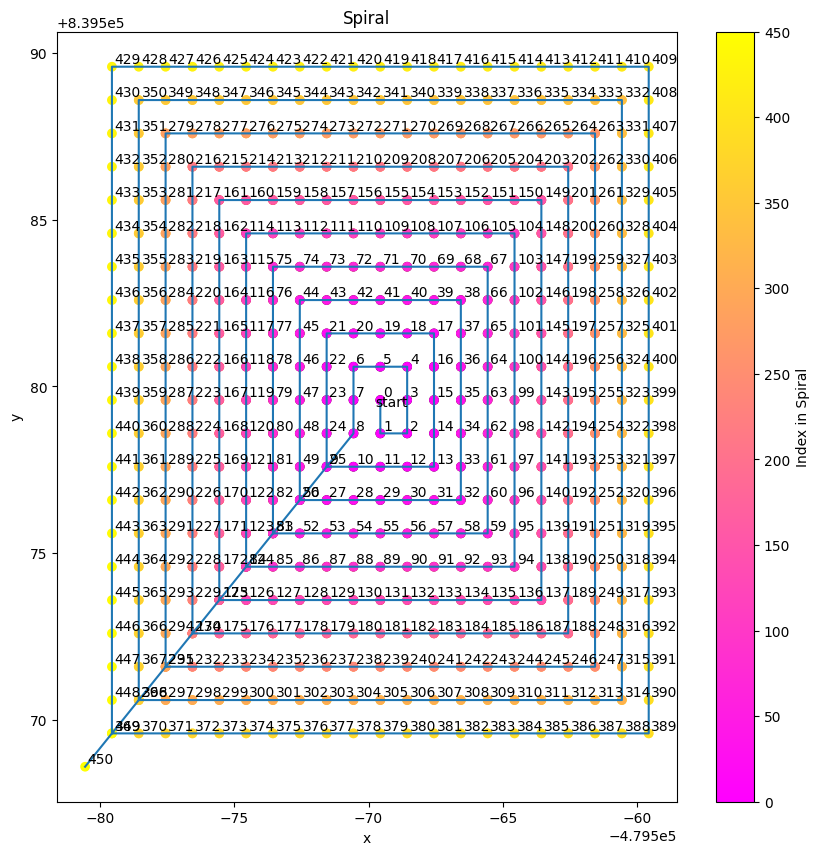

In [23]:
# plot the spiral around the point
plot_spiral(x,y, 10)

In [24]:
#print x min and max
min = np.min(iceflow_data[0])
max = np.max(iceflow_data[0])

print(f"min: {min}, max: {max}")

print(f"min/450: {min/450}, max/450: {max/450}")

one, two, three = (iceflow_data[1][0], iceflow_data[1][1], iceflow_data[1][2])
print(f"one: {one}, two: {two}, three: {three}")
print(f"one - two: {one - two}, two - three: {two - three}")

min: -2800000.0, max: 2799800.0
min/450: -6222.222222222223, max/450: 6221.777777777777
one: 2800000.0, two: 2799550.0, three: 2799100.0
one - two: 450.0, two - three: 450.0


In [25]:
def x_to_index(x):
    return 6223 + int(x/450)
def y_to_index(y):
    return 6223 - int(y/450)
def index_to_x(x):
    return (x - 6223) * 450
def index_to_y(y):
    return (6223 - y) * 450

# ~~TODO: see if these are even legal lat-lon values~~
- **they are not but neither are the iceflow data values**
- some of these longitudes don't work in Google Earth, I think they are supposed to be between -180 and 180
- more importantly, are the icflow data and CReSIS lat-lon values in this format (i.e. if they are wrong, stay wrong)

Iceflow data: 
    - max lat: -89.9 - 0 degrees
    - min lat: 0 - 359.79 degrees
    

In [26]:
x = 6000
y = 1000
print(f"starting values\nx: {x}, y: {y}")
x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")
print(f"x: {iceflow_data[0][x_index]}, y: {iceflow_data[1][y_index]}\n")

x = 9000
y = 5000
print(f"starting values\nx: {x}, y: {y}")
x_index = x_to_index(x)
y_index = y_to_index(y)
print(f"x_index: {x_index}, y_index: {y_index}")
print(f"x: {iceflow_data[0][x_index]}, y: {iceflow_data[1][y_index]}\n")



starting values
x: 6000, y: 1000
x_index: 6236, y_index: 6221
x: 6200.0, y: 550.0

starting values
x: 9000, y: 5000
x_index: 6243, y_index: 6212
x: 9350.0, y: 4600.0



In [27]:
# for testing purposes only, delete when done
def find_heading_test(lat1, lon1, lat2, lon2):
    # print the lat-lon points
    # print(f"lat-lon input to find_heading:"
    #       f"\n({layer.lat[index]}, {layer.lon[index]})")
    geodesic = pyproj.Geod(ellps='WGS84')
    # lon = layer.lon[index]
    # lat = layer.lat[index]
    # lon1 = layer.lon[index - window_size]
    # lat1 = layer.lat[index - window_size]
    # lon2 = layer.lon[index + window_size]
    # lat2 = layer.lat[index + window_size]

    print(f"lat-lons determined by find_heading:"
          f"\n({lat1}, {lon1}), ({lat2}, {lon2})")
    # delta_lon1 = lon - lon1
    # delta_lat1 = lat - lat1
    # delta_lon2 = lon2 - lon
    # delta_lat2 = lat2 - lat
    # print(f"delta_lon1: {delta_lon1}, delta_lat1: {delta_lat1}, delta_lon2: {delta_lon2}, delta_lat2: {delta_lat2}")
    fwd_azimuth, back_azimuth, distance = geodesic.inv(lon1, lat1, lon2, lat2)
    return fwd_azimuth

In [28]:
def find_heading_points(layer, index, window_size=100):
    """
    :param layer: a Layer object
    :param index: the index of the point in the layer
    :param window_size: the number of points to use in the slope calculation
    :return: the bearing of the current that flew through the points.
    This has nothing to do with the slope of the layer. only the lat-lon points.
    """
    # print the lat-lon points
    print(f"lat-lon input to find_heading:"
          f"\n\t({layer.lat[index]}, {layer.lon[index]})")
    geodesic = pyproj.Geod(ellps='WGS84')
    lon = layer.lon[index]
    lat = layer.lat[index]
    lon1 = layer.lon[index - window_size]
    lat1 = layer.lat[index - window_size]
    lon2 = layer.lon[index + window_size]
    lat2 = layer.lat[index + window_size]
    
    return lon1, lat1, lon2, lat2